# Relax Data Science Challenge
****
This is a simple take home challenge in which I am tasked with finding which factors predict engagement. One of the supplied csv's provides the features or factors, while the other one will be used to define the target variable.

Once we have cleaned the data we will use correllation and xgboost to find feature importance.

In [36]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import datetime
import math
import json

# visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# feature prediction
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

In [22]:
users = pd.read_csv('./data/takehome_users.csv', encoding = "ISO-8859-1")
engagement = pd.read_csv('./data/takehome_user_engagement.csv', encoding = "ISO-8859-1")
engagement['time_stamp'] = engagement['time_stamp'].str.split(' ',expand=True)[0]
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

## Data Cleaning
****
First we will create our target variable, "engaged," which is if a user logged in during three days within a 7 day period. We will do this with a rather slow but straight forward counting loop.

Note: We are counting this over a "rolling" 7 day period rather than a defined calendar week.

In [23]:
# The slow approach
users['engaged'] = 0
for i in users.index:
    user_df = engagement[engagement['user_id'] == i+1] # the object_id is always 1 greater than the index
    # We only count daily logins once, so multiple logins per day have to be aggregated.
    user_df = user_df.groupby('time_stamp').mean().reset_index() 
    max_week = 0
    for time in user_df['time_stamp']:
        # This counts the number of entries that occur within 7 subsequent days
        visits = len(user_df[(user_df['time_stamp'] <= time + datetime.timedelta(days=7)) & # upper limit
                             (user_df['time_stamp'] >= time)]) # lower limit
        # if we get 3, we update and break the loop
        if visits >= 3:
            users.at[i, 'engaged'] = 1
            break
        
users = users.set_index('object_id').drop(['name', 'email'], axis = 1) #name and email are not relevant

Here we will clean our data and fill in null values.

In [24]:
le = LabelEncoder()
# Fill null values
users['invited_by_user_id'].fillna(0, inplace=True) # use a user_id of 0 for those who are not referred
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

# create a feature that give the age of the account
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])
# If last session is blank then assume they never returned and creation was last session
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)
users['account_age'] = users['last_session_creation_time'] - users['creation_time']
users['account_age'] = users['account_age'].dt.days
#users = users.drop(['creation_time', 'last_session_creation_time']) # with account_age, we wont need these

# convert creation_source to categorical int
users['creation_source'] = le.fit_transform(users['creation_source'])

Lets deal more with org_id. This is a categorical variable but it has many categories. Lets see if we can't bin some of them.

In [41]:
series_1 = pd.value_counts(users['org_id'])
mask_1 = (series_1/series_1.sum() * 950).lt(1)
users['org_adj'] = np.where(users['org_id'].isin(series_1[mask_1].index),5000,users['org_id'])

## XgBoost feature importance

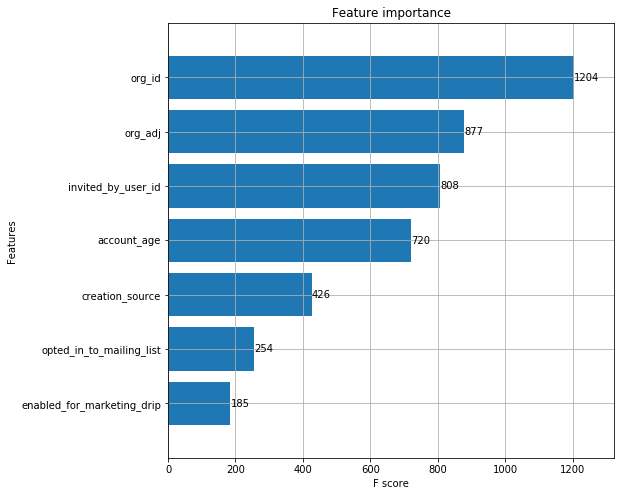

In [40]:
train_y = users['engaged'].values
df_train = users.drop(['engaged', 'creation_time', 'last_session_creation_time'], axis=1)
feat_names = df_train.columns.values

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Conclusions
****
Here we can see that the organization the person belongs to and whether or not they were invited have a very large effect on if they become "adopted." Meanwhile, mailing lists and marketting drips do not.

We also observe that our modified org_adj which combined the smallest orgs into one was less important than the original one and so doesnt need to be included.

Account age also shows some importance as well. This is to be expected as the longer a user is around the more likely it is they will use it multiple times in one week.